# CNN used to solve the problem denoise the noise version of the image

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import torch, torch.nn   as nn #pytorch = deep learning frameword; nn= neural network module comes with pytorch
from IPython.display     import display, clear_output  #to siplay inline using IPython library

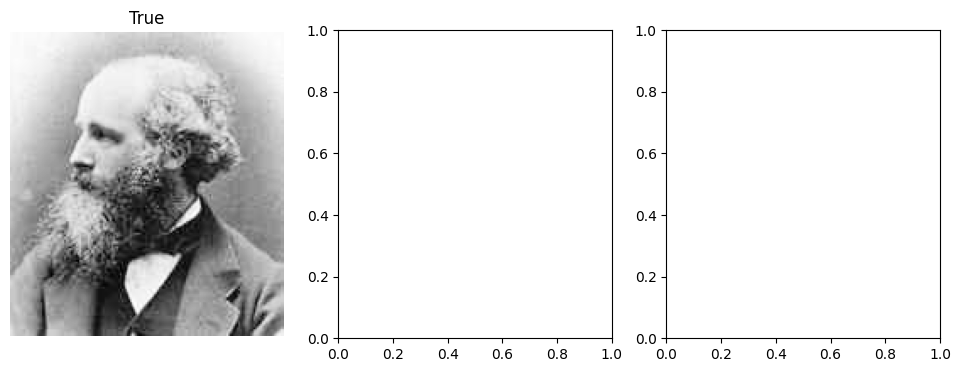

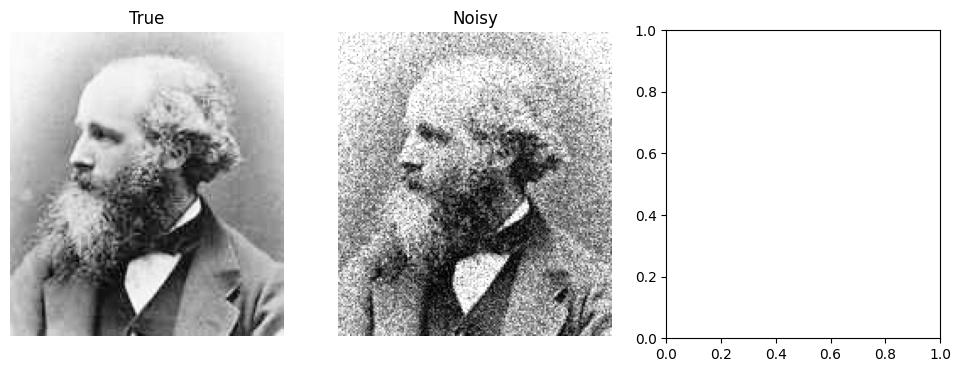

In [7]:
true_object_np = plt.imread('jcm.jpeg') #reading image
true_object_np = 0.1*true_object_np[:,:,0] #first grab one of the RGB channel true_object_np[:,:,0] & reduce the size of the value; not impacting the true image


fig1, axs1 = plt.subplots(1,3, figsize=(12,4)) # No. rows, cols,  figsize Width,Height (inches)
axs1[0].imshow(true_object_np,cmap='Greys_r'); 
axs1[0].set_title('True'); 
axs1[0].set_axis_off()


#to use noisy version of the image use different data types; instead of numpy array use tocrch tensors

def np_to_torch(np_array):      return torch.from_numpy(np_array).float() #np_to_torch which will take np_array such as true_object_np and this will going to convert the torch sensor torch.from_numpy(np_array) which is suitable for CNN (covert numpy array to torch)
def torch_to_np(torch_array):   return np.squeeze(torch_array.detach().cpu().numpy()) #torch_to_np which will take torch_array (torch tensor array) which will detach from computational graph and make sure on cpu and render the array as an numpy (convert torch to numpy)

device         = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #define what device is

#create a noisy version of the image which will train in CNN
true_object_torch    = np_to_torch(true_object_np).to(device) #np array converted to torch
noisy_image_torch    = torch.poisson(true_object_torch) #now in a torch sensor and this will convert into noise with poisson noisy version 

#torch sensor for deep learning to visualize true result converting np to torch and plotting 

fig1, axs1 = plt.subplots(1,3, figsize=(12,4)) # No. rows, cols,  figsize Width,Height (inches)
axs1[0].imshow(torch_to_np(true_object_torch),cmap='Greys_r'); axs1[0].set_title('True'); axs1[0].set_axis_off(); #converted torch true object into np array (torch_to_np(true_object_torch)
axs1[1].imshow(torch_to_np(noisy_image_torch), vmin=0,vmax=np.max(true_object_np),cmap='Greys_r'); axs1[1].set_title('Noisy'); axs1[1].set_axis_off(); #plotting noisy version of image

# CNN to denoise the noisy image

In [8]:
#class in pytorch which inherits from nueral netowrk module

class CNN(nn.Module):
    #standard initialization and supplying number of output channels
    def __init__(self, num_channels):
        #initialization of base class inheriting from neural network
        super(CNN, self).__init__()
        #core definition of CNNs; it is composed of number of layers, seqent or Cascade of layers
        self.CNN = nn.Sequential(
            #here 1 means no. of input chanel to the CNN layer, 1 is because it is noisy image; than no. of output channels with num_channels and we'll be supplying that we can choose when we first initiate this class as an object; than size of kernel for conf2d that would be three by three(3x3) kernel; than padding to pad the image so that 3x3 kernel can correctly go to the edge and operate on padded pixel value so this not change the size of the image whenit comes out of conv 2D layer and now this conv 2D layer have one input channel and num_channles are the output channels this means that this many Convolutional Layer; padding=1 is the global ofset of those output channel images; Finally, run through nn.PReLU() i.e. non linearity this is effectively a modified version of the relu, rectified linear unit, basically sets negatives to zero and retains the positive values it's a non-linearity a kind of a thresholding operation. 
            #using the parametric version of it just to soften it so it doesn't actually set negatives to zero but it can train up the level to which negative values are suppressed so that's the first two layers in our defined CNN
            nn.Conv2d(1,            num_channels, 3, padding=1), nn.PReLU(),
            #another conf2d layer but now this needs to operate not on one input Channel which was the case for the first leg so there's only one noisy input here now is going to be operating on all of the output channels all all of the output feature maps from that first conv 2D layer
            nn.Conv2d(num_channels, num_channels, 3, padding=1), nn.PReLU(),
            nn.Conv2d(num_channels, num_channels, 3, padding=1), nn.PReLU(),
            #here in last layer no. of output channels as a feature maps which will go in last Conv2D layer, here we only want 1 output channel i.e. one output image
            #because of course we want something hopefully close to the true okay and that's one single output image again we're still using a three by three kernel and in this case the three by three kernel just to be clear there'd only be one of these three by three kernels but that three by three kernel will actually have this number of channels to it so it'll have so it'll have quite a number of values in it but spatially it'd be three by three and it'll have to have this many instances versions of that kernel in order to operate on that many coming input channels so this convolutional 2D layer right okay so that's the definition of the CNN
            nn.Conv2d(num_channels, 1,            3, padding=1), nn.PReLU()
        )
    #when the object created for CNN class is called by the forward() and this will take an input image(x) and padded(unsqueeze(0).unsqueeze(0)) with couple of extra dimensions because CNN 2D layer actual have a batch number & channel number and images always dealing with 2D image, and this will sequeeze back to regular 2D image by using torch.squeeze     
    def forward(self, x):
        x = torch.squeeze(self.CNN(x.unsqueeze(0).unsqueeze(0)))
        return x

#instantiating the class inwards and create an object from that CNN class and now this going to concretize and put in a hard value here 64 for the number of output channels so that means at the very start this noisy image will go in and it'll generate 64 different feature maps and this will go to the process   
cnn = CNN(64).to(device)    

In [9]:
#now trying using CNN that already instantiated above
output_cnn = cnn(noisy_image_torch)

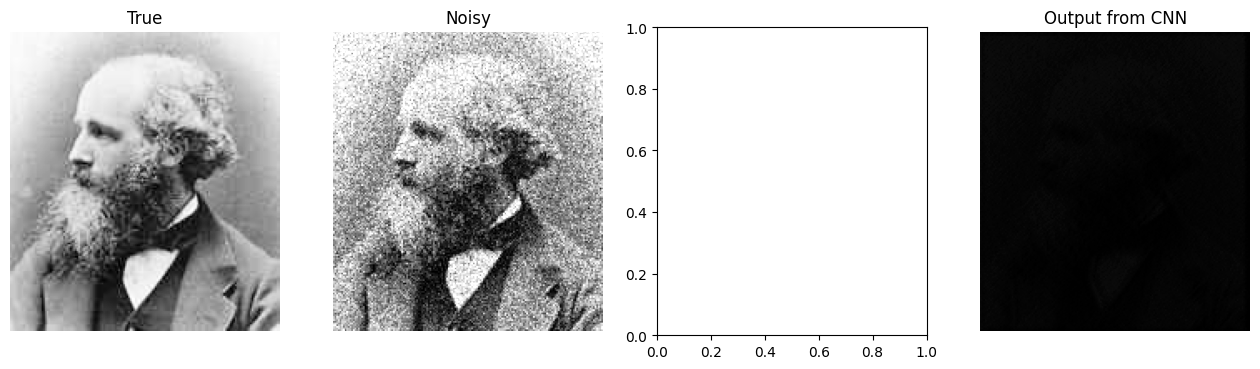

In [15]:
fig1, axs1 = plt.subplots(1,4, figsize=(16,4)) # No. rows, cols,  figsize Width,Height (inches)
axs1[0].imshow(torch_to_np(true_object_torch), vmin=0,vmax=np.max(true_object_np), cmap='Greys_r'); 
axs1[0].set_title('True'); 
axs1[0].set_axis_off();
axs1[1].imshow(torch_to_np(noisy_image_torch), vmin=0,vmax=np.max(true_object_np), cmap='Greys_r'); 
axs1[1].set_title('Noisy'); 
axs1[1].set_axis_off();

#run through an output(above) to get an output to CNN 
axs1[3].imshow(torch_to_np(output_cnn), vmin=0,vmax=np.max(true_object_np), cmap='Greys_r'); 
axs1[3].set_title('Output from CNN'); 
axs1[3].set_axis_off();

# Training CNN

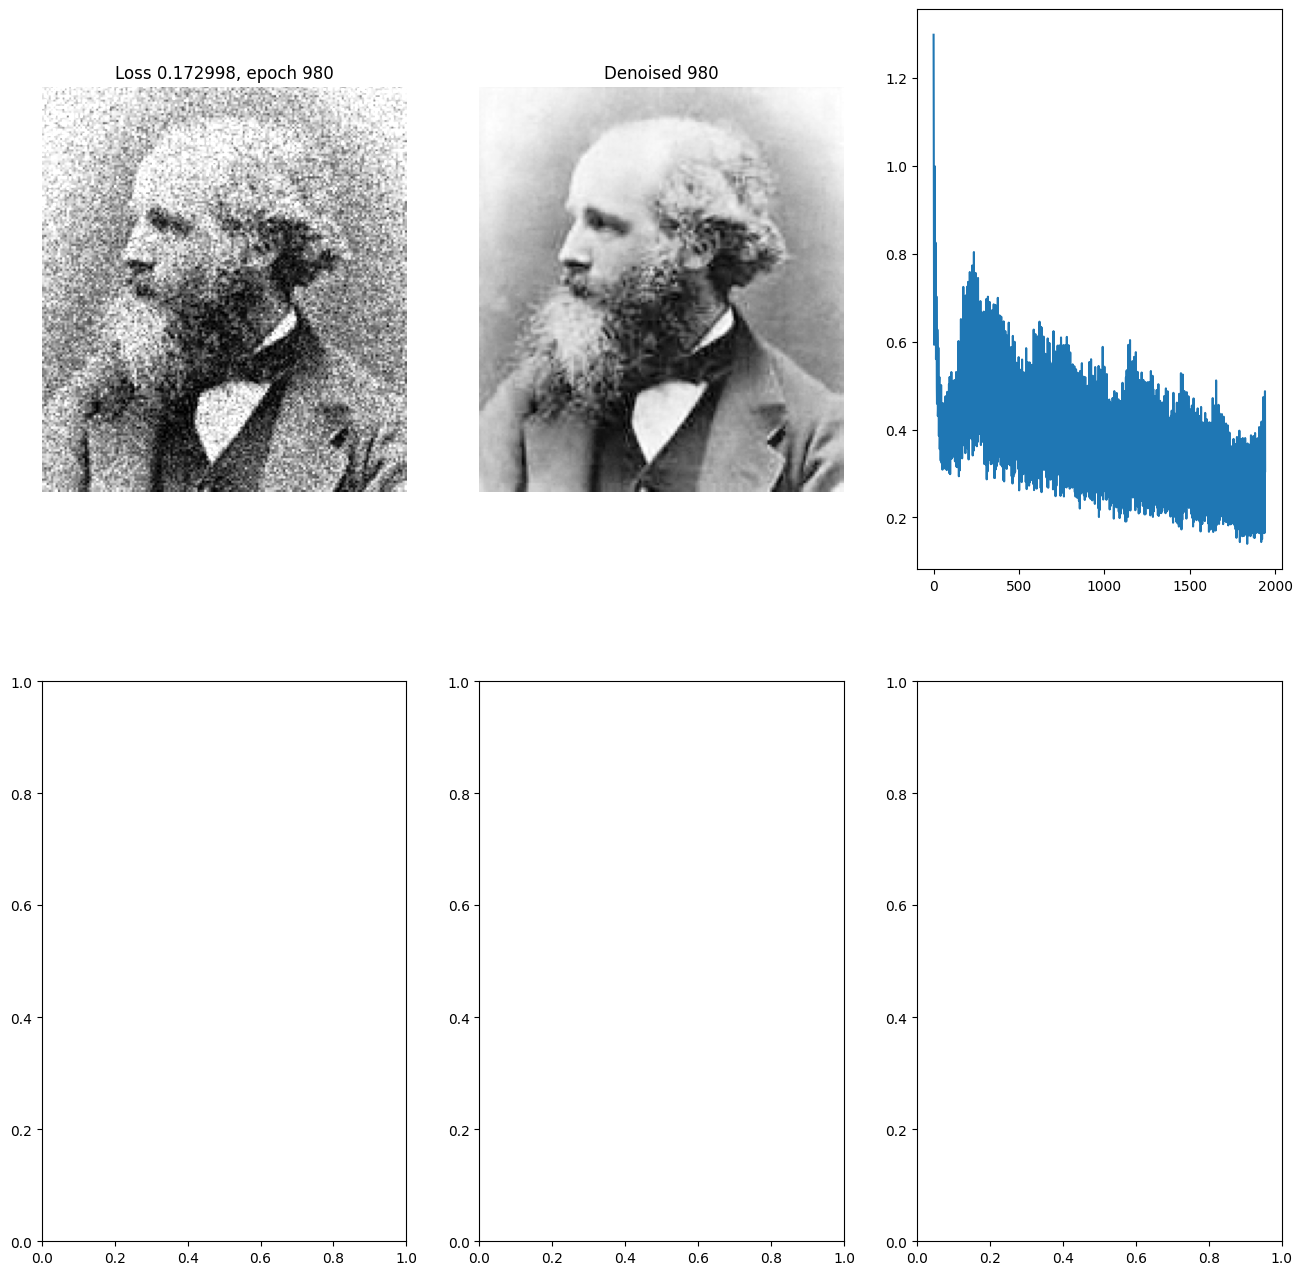

In [17]:
#to train CNN we need to use an objective or a cost or a loss function, this means MSELoss() i.e. mean square error which take a look at the output from CNN and it compares with the target or labels or reference should be  
#so in the first instance here we'll be training with a reference being our true and so the mean square error will look at the output from our CNN compare it to the true and then that will describe how well the CNN is doing in other words it's a loss function or a cost function
loss_fun  = nn.MSELoss()

#torch.optim is used to optimize the value for CNN how CNN is work bad or good here I sued Adam optimizer to optimize the value
#Also, Adam Optimizer is the variation of stochastic gradient descent it's going to take the gradient of that loss function and we'll back propagate the gradients through the CNN in order to be able to update all the parameters in the CNN so that Adam Optimizer is going to use the parameters all those kernel values and so on the op the biases the parametric relus it's going to take those parameters and update them according to the loss function defiend above
#lr stands for Learning Rate comparable to a step size i.e. how much do we actually make changes to parameters based on the gradients
optimiser = torch.optim.Adam(cnn.parameters(), lr=1e-3)

train_loss = list()
epochs     = 1000 #number of training iteration

#training loop for CNN, here ep is epoch number
for ep in range(epochs):
    optimiser.zero_grad() # set the gradients to zero
    
    
    #cnn object oerating on that noisy_image_torch 
    output_cnn = cnn(noisy_image_torch)
    #here loss given by loss_fun and squeezing to remove extra dimensions left behind I haven't double checked, here using supervised learning of knowledge of true i.e. true_object_torch, lable the target in a loss function
    loss = loss_fun(torch.squeeze(output_cnn), torch.squeeze(true_object_torch))
 

    #denoise result for the above case i.e. loss.....
    denoised_result = output_cnn
    
    #here record the loss function value
    train_loss.append(loss.item())
    loss.backward() # Find the gradients of the loss(); with respect to all of the parameters in the CNN convolutional neural network and other words all the parameters all the kernel values and so on find the gradient of the loss function with respect to those parameters
    #once found the gradients through back propagating through that computational graph of the CNN what we're then going to do is actually update the parameters so that's Optimizer with a step actually performing if you like the adding on or in fact the subtraction of the gradients whichever way we'll looking at it so that will actually achieve an iterative gradient-based training of the parameters of our CNN
    optimiser.step() # Does the update  
    
    if ep % 20 == 0:
        fig2, axs2 = plt.subplots(2,3, figsize=(16,16)) # No. rows, cols,  figsize Width,Height (inches)
        axs2[0,0].set_axis_off(); axs2[0,1].set_axis_off() 
        axs2[0,0].imshow(torch_to_np(noisy_image_torch), vmin=0,vmax=np.max(true_object_np),cmap='Greys_r'); axs2[0,0].set_title('Noisy Input %d x %d' % (true_object_np.shape[0],true_object_np.shape[1]))
        axs2[0,1].imshow(torch_to_np(denoised_result), vmin=0,vmax=np.max(true_object_np), cmap='Greys_r'); axs2[0,1].set_title('Denoised %d' % (ep))
        axs2[0,2].plot(train_loss[19:-1]);  axs2[0,0].set_title('Loss %f, epoch %d' % (train_loss[-1],ep));   
        clear_output(wait=True); plt.pause(0.001)
    
    output_cnn = cnn(noisy_image_torch)
    loss = loss_fun(torch.squeeze(output_cnn), torch.squeeze(true_object_torch))
 

    denoised_result = output_cnn
    
    train_loss.append(loss.item())
    loss.backward() # Find the gradients
    optimiser.step() # Does the update  
    
    #supervised learning
    #after every 20 epochs it will open up ploting figure
    if ep % 20 == 0:
        fig2, axs2 = plt.subplots(2,3, figsize=(16,16)) # No. rows, cols,  figsize Width,Height (inches)
        axs2[0,0].set_axis_off(); axs2[0,1].set_axis_off() 
        axs2[0,0].imshow(torch_to_np(noisy_image_torch), vmin=0,vmax=np.max(true_object_np),cmap='Greys_r'); axs2[0,0].set_title('Noisy Input %d x %d' % (true_object_np.shape[0],true_object_np.shape[1]))
        axs2[0,1].imshow(torch_to_np(denoised_result), vmin=0,vmax=np.max(true_object_np), cmap='Greys_r'); axs2[0,1].set_title('Denoised %d' % (ep))
        axs2[0,2].plot(train_loss[19:-1]);  axs2[0,0].set_title('Loss %f, epoch %d' % (train_loss[-1],ep));   
        clear_output(wait=True); plt.pause(0.001)